In [1]:
# encoding: utf-8
import os
import time
import logging
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

time = int(time.time())
SCRIPT_EXEC_TIMESTAMP = "{:.0f}".format(time)
logging.basicConfig(format=u"%(asctime)s : %(levelname)s : %(message)s",
                    handlers=[
                        logging.StreamHandler()
                    ],
                    level=logging.DEBUG
                )
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib.font_manager').disabled = True
logger.info('Script starts, timestamp for execution: {}'.format(
    SCRIPT_EXEC_TIMESTAMP))


2024-10-12 23:39:12,207 : INFO : Script starts, timestamp for execution: 1728769152


In [2]:
# Write to current path
path = "."

# Read call data
calls_df = pd.read_csv(os.path.join(path, 'data', "telehealth_calls.csv"))

# Parse dates and clean data
calls_df['date'] = pd.to_datetime(calls_df['date'])
calls_df.loc[calls_df['region'] == 'västragötland', 'region'] = 'västragötaland'
calls_df.loc[calls_df['region'] == 'sörmland', 'region'] = 'södermanland'

# Read ED visits data
visits_df = (pd.read_csv(os.path.join(path, 'data', "ed_visits.csv"), index_col=0)
             .rename(columns={"Mätperiod": "date", "Värde": "visits", "Enhetsnamn": "region"})
             [['date', 'visits', 'region']]
)
visits_df['date'] = pd.to_datetime(visits_df['date'], format="%Y-%m")
visits_df.set_index('date', inplace=True)
visits_psych_df = (pd.read_csv(os.path.join(path, 'data', "ed_psychiatric_visits.csv"), index_col=0)
            .rename(columns={"Mätperiod": "date", "Värde": "visits", "Enhetsnamn": "region"})
             [['date', 'visits', 'region']]
)

# Read psychiatric visits data
visits_psych_df['date'] = pd.to_datetime(visits_psych_df['date'], format="%Y-%m")
visits_psych_df.set_index('date', inplace=True)

# Read population data
citizen_df = pd.read_csv(os.path.join(path, 'data', "statistics_sweden_population.csv"), index_col=0)

In [3]:
# Mean number of calls per month to 1177
mean_per_month = calls_df.groupby('date')['calls_total'].sum().mean()
std_per_month = calls_df.groupby('date')['calls_total'].sum().std()
print(f"Mean number of calls per month: {mean_per_month}, (SD {std_per_month})")

# Mean number of calls per capita per month to 1177
# Iterate of all regions and calculate calls per capita
tmp_df = calls_df[calls_df['date'] < '2022-01-01'].set_index('region_id')
tmp_df['year'] = tmp_df['date'].dt.year
l = []
for i, row in tmp_df.iterrows():
    l.append(citizen_df.loc[i, str(row.year)])
tmp_df['population'] = l
tmp_df['calls_per_capita'] = tmp_df['calls_total'] / (tmp_df['population']/1000)
tmp_df['calls_missed_per_capita'] = tmp_df['calls_missed'] / (tmp_df['population']/1000)

cpc_per_month = tmp_df['calls_per_capita'].mean()
cpc_per_month_std = tmp_df['calls_per_capita'].std()
print(f"Mean number of calls per 1000 and month: {cpc_per_month}, (SD {cpc_per_month_std})")

Mean number of calls per month: 329770.84523809527, (SD 162382.53561619375)
Mean number of calls per 1000 and month: 48.04076673595946, (SD 10.002956183418595)


2024-10-08 22:11:49,377 : DEBUG : Importing BlpImagePlugin
2024-10-08 22:11:49,380 : DEBUG : Importing BmpImagePlugin
2024-10-08 22:11:49,380 : DEBUG : Importing BufrStubImagePlugin
2024-10-08 22:11:49,381 : DEBUG : Importing CurImagePlugin
2024-10-08 22:11:49,382 : DEBUG : Importing DcxImagePlugin
2024-10-08 22:11:49,384 : DEBUG : Importing DdsImagePlugin
2024-10-08 22:11:49,386 : DEBUG : Importing EpsImagePlugin
2024-10-08 22:11:49,387 : DEBUG : Importing FitsImagePlugin
2024-10-08 22:11:49,388 : DEBUG : Importing FliImagePlugin
2024-10-08 22:11:49,389 : DEBUG : Importing FpxImagePlugin
2024-10-08 22:11:49,390 : DEBUG : Image: failed to import FpxImagePlugin: No module named 'olefile'
2024-10-08 22:11:49,391 : DEBUG : Importing FtexImagePlugin
2024-10-08 22:11:49,393 : DEBUG : Importing GbrImagePlugin
2024-10-08 22:11:49,395 : DEBUG : Importing GifImagePlugin
2024-10-08 22:11:49,396 : DEBUG : Importing GribStubImagePlugin
2024-10-08 22:11:49,397 : DEBUG : Importing Hdf5StubImagePlugi

Number of answered calls per capita per month37.835190390033326, (SD 8.749465610067812)


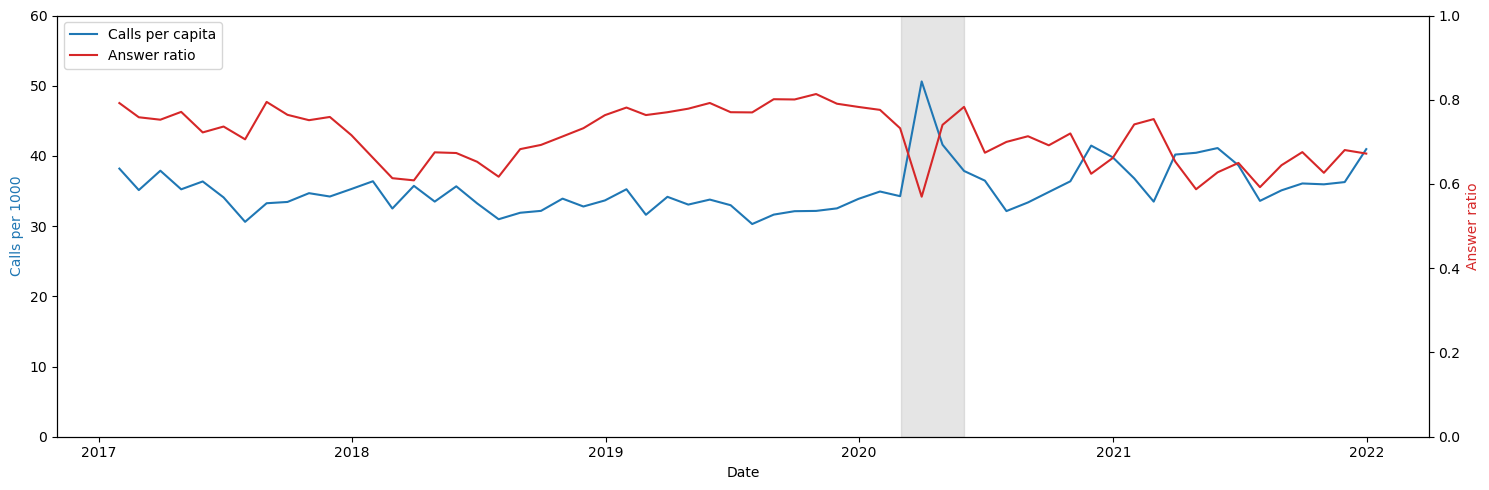

In [19]:
# Create a new dataframe with calls and visits
census_df = citizen_df
census_df['region'] = census_df['region'].str.lower().str.replace(' ', '')
groupby = calls_df[calls_df['date'] < '2023-01-01'].groupby('date')
calls_and_citizen = pd.DataFrame(columns=['date', 'calls', 'calls_missed', 'citizen', 'answer_ratio', 'total_calls'])
for i, date in enumerate(groupby.groups.keys(), 0):
    calls_and_citizen.loc[i] = [
        date, 
        groupby.get_group(date)['calls_answered'].sum(),
        groupby.get_group(date)['calls_missed'].sum(),
        census_df.loc[census_df.index.isin(groupby.get_group(date)['region_id'].values), str(date.year)].sum(),
        groupby.get_group(date)['calls_answered_ratio_calc'].median(),
        groupby.get_group(date)['calls_answered'].sum() + groupby.get_group(date)['calls_missed'].sum()
    ]
calls_and_citizen['calls_per_capita'] = calls_and_citizen['calls'] / (calls_and_citizen['citizen']/1000)
calls_and_citizen['calls_missed_per_capita'] = calls_and_citizen['calls_missed'] / (calls_and_citizen['citizen']/1000)
calls_and_citizen['total_calls_per_capita'] = calls_and_citizen['total_calls'] / (calls_and_citizen['citizen']/1000)

cpc_plot_df = calls_and_citizen[calls_and_citizen['date'] < '2022-01-01']

# Plot calls per capita and answer ratio
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(cpc_plot_df['date'], cpc_plot_df['calls_per_capita'], label="Calls per capita", color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Calls per 1000', color='tab:blue')
ax1.set_ylim([0, 60])
plt.axvspan(datetime(2020, 3, 1), datetime(2020, 5, 31), alpha=0.2, color='grey')
plt.savefig(os.path.join(path, 'figures', 'figure_1_calls_per_capita.tiff'), dpi=600)

ax2 = ax1.twinx()
ax2.plot(cpc_plot_df['date'], cpc_plot_df['answer_ratio'], label='Answer ratio', color='tab:red')
ax2.set_ylabel('Answer ratio', color='tab:red')
ax2.set_ylim([0, 1])
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.savefig(os.path.join(path, 'figures', 'calls_per_capita_combined.jpg'), dpi=600)


# Mean number of calls per capita per month to 1177
cpc_mean = calls_and_citizen['calls_per_capita'].mean()
cpc_std = calls_and_citizen['calls_per_capita'].std()
print(f"Number of answered calls per capita per month{cpc_mean}, (SD {cpc_std})")

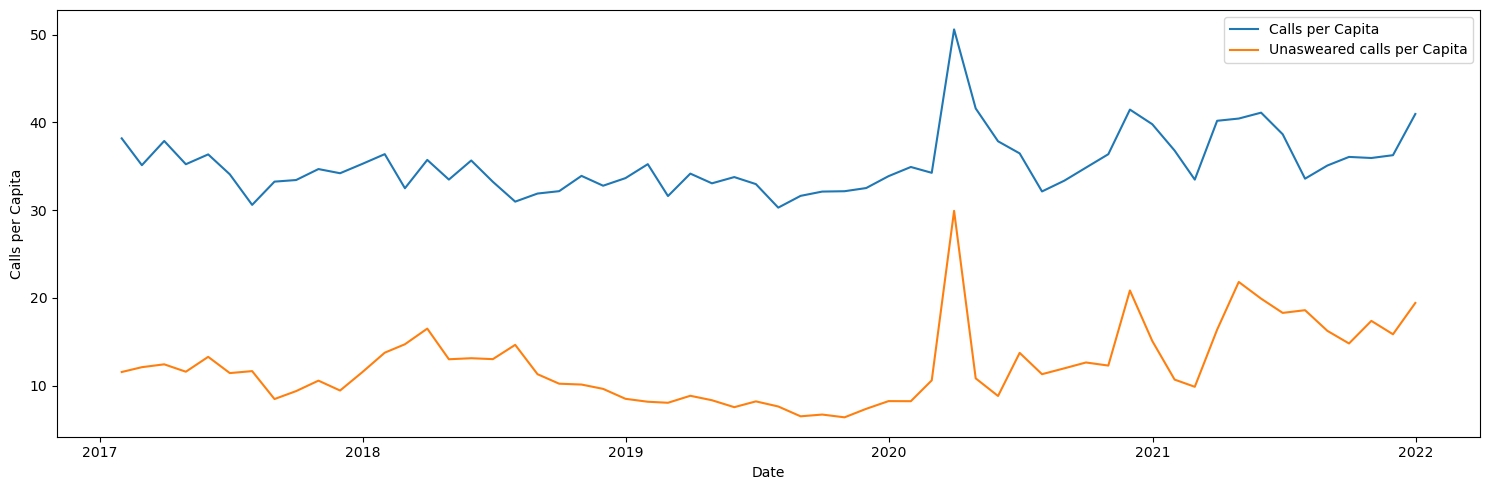

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

# Plotting calls_per_capita
ax.plot(cpc_plot_df['date'], cpc_plot_df['calls_per_capita'], label='Calls per Capita')

# Plotting calls_missed_per_capita
ax.plot(cpc_plot_df['date'], cpc_plot_df['calls_missed_per_capita'], label='Unasweared calls per Capita')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Calls per Capita')

# Adding legend
plt.legend()

# Displaying the plot'
plt.tight_layout()
plt.savefig(os.path.join(path, 'figures', 'calls_and_unanswered_calls_per_capita.jpg'), dpi=600)


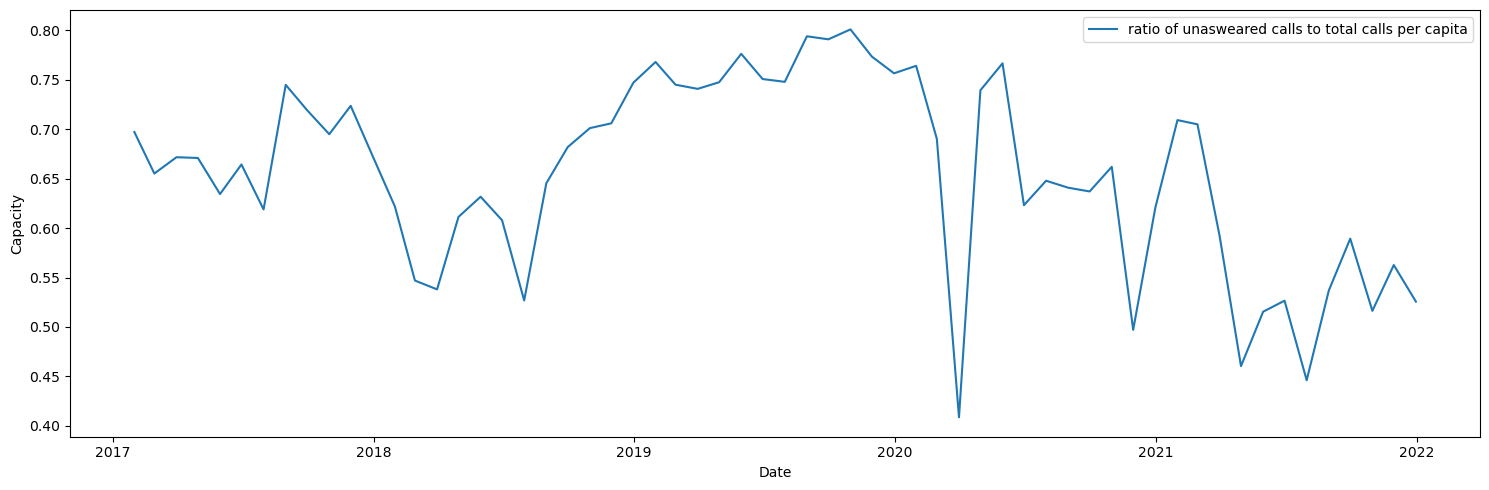

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

# Plotting calls_per_capita
ax.plot(cpc_plot_df['date'], 1 - (cpc_plot_df['calls_missed_per_capita']/cpc_plot_df['calls_per_capita']), label='ratio of unasweared calls to total calls per capita')

# Plotting calls_missed_per_capita
#ax.plot(cpc_plot_df['date'], cpc_plot_df['calls_missed_per_capita'], label='Unasweared calls per Capita')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Capacity')

# Adding legend
plt.legend()

# Displaying the plot'
plt.tight_layout()
plt.savefig(os.path.join(path, 'figures', 'figure_2_capacity.jpg'), dpi=600)


2024-10-08 22:11:52,457 : INFO : Linear regression calls_per_capita and answer_ratio
2024-10-08 22:11:52,457 : INFO : RESULT: linreg slope: 0.9546, r2: 0.5572, p: 7.574370171681047e-12


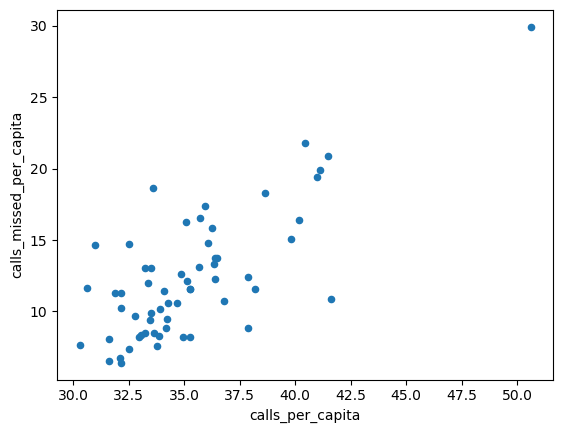

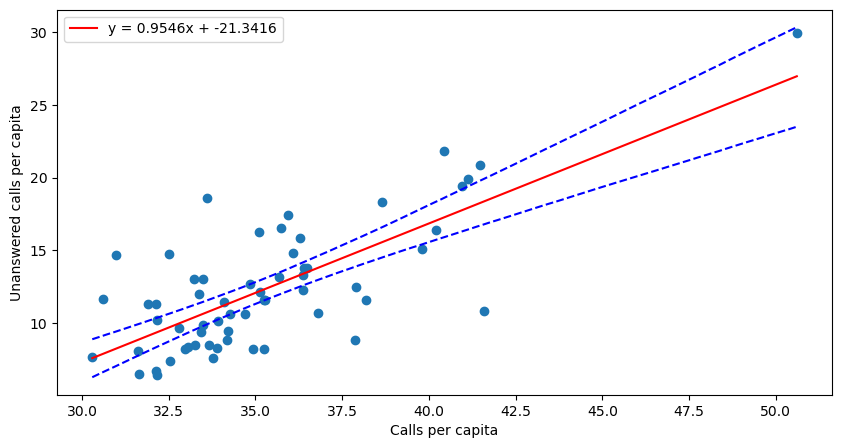

In [22]:
from research_tools.analysis.stats.helpers import linregress

def log_linreg(x, y, linreg_res):
    logger.info('Linear regression {} and {}'.format(x, y))
    logger.info('RESULT: linreg slope: {}, r2: {},'.format(np.round(
    linreg_res.slope, 4), np.round(linreg_res.r_squared, 4))+" p: {}".format(linreg_res.p))


cpc_plot_df.plot.scatter(x='calls_per_capita', y='calls_missed_per_capita')

linres = linregress(cpc_plot_df['calls_per_capita'].values, cpc_plot_df['calls_missed_per_capita'].values)
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(cpc_plot_df['calls_per_capita'].values, cpc_plot_df['calls_missed_per_capita'].values)
ax.plot(linres.x, linres.regline, color='r', label='y = {}x + {}'.format(np.round(linres.slope, 4), np.round(linres.intercept, 4)))
ax.plot(linres.x, linres.ci_upper, color='b', ls='--')
ax.plot(linres.x, linres.ci_lower, color='b', ls='--')
plt.xlabel('Calls per capita')
plt.ylabel('Unanswered calls per capita')
plt.legend()
plt.savefig(os.path.join(path, 'figures', 'supplemental_capacity_linregress.jpg'), dpi=600)

log_linreg('calls_per_capita', 'answer_ratio', linres)


INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast_irreg(),set print.options = 0 
INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast_irreg(),      set quiet = 1 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 72
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
HasSeasonCmpnt: True  | period = 12 (unknown unit). The model 'Y=Trend+Season+Error' is fitted.
              : Num_of_DataPoints_per_Period = period/deltaTime = 12/1 = 12
HasOutlierCmpt: False | If true, Y=Trend+Season+Outli

/Users/jens/miniconda3/envs/Research2024/lib/python3.12/site-packages/Rbeast/plotbeast.py:294: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 9 Axes>,
 array([<Axes: xlabel='[]', ylabel='Y'>,
        <Axes: xlabel='[]', ylabel='season'>,
        <Axes: xlabel='[]', ylabel='Pr(scp)'>,
        <Axes: xlabel='[]', ylabel='sOrder'>,
        <Axes: xlabel='[]', ylabel='trend'>,
        <Axes: xlabel='[]', ylabel='Pr(tcp)'>,
        <Axes: xlabel='[]', ylabel='tOrder'>,
        <Axes: xlabel='[]', ylabel='slpsgn'>,
        <Axes: xlabel='time', ylabel='error'>], dtype=object))

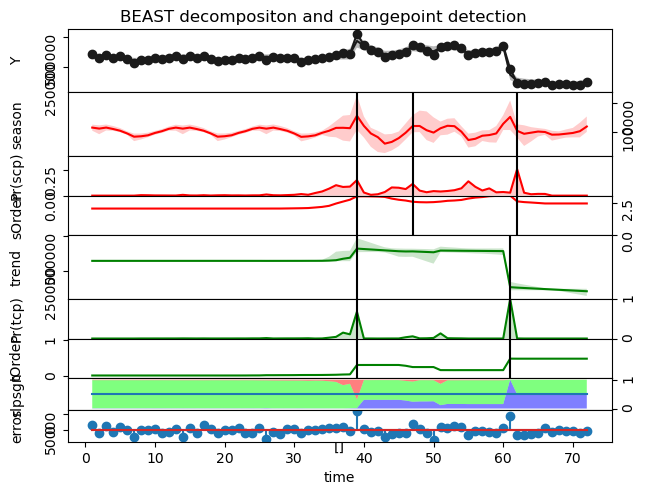

In [23]:
import Rbeast as rb
o = rb.beast(calls_and_citizen['calls'], freq=12)
rb.plot(o)

In [24]:
# Ratio answered calls to total calls
answer_ratio_median = calls_df.groupby('region')['calls_answered_ratio_calc'].median().median()
answer_ratio_q25 = calls_df.groupby('region')['calls_answered_ratio_calc'].median().quantile(0.25)
answer_ratio_q75 = calls_df.groupby('region')['calls_answered_ratio_calc'].median().quantile(0.75)
print(f"{answer_ratio_median} (IQR {answer_ratio_q25}-{answer_ratio_q75})")

0.6974222031499999 (IQR 0.6715337461499999-0.80766359725)


In [25]:
# Number of calls during the first month of the pandemic
from scipy.stats import ttest_rel, mannwhitneyu

calls_df = tmp_df

calls_first_month = calls_df.loc[calls_df['date'] == datetime(2020, 3, 31), 'calls_total'].sum()
three_month_df = pd.DataFrame(columns=['year', 'mean', 'std', 't', 'p', 'diff(95% CI)', 'capacity'])
one_year_df = three_month_df.copy()
comp_month = calls_df.loc[(calls_df['date'] > datetime(2020, 3, 1)) & (calls_df['date'] < datetime(2020, 6, 1)), ['date', 'calls_per_capita']].groupby('date').mean()['calls_per_capita']
comp_month_cap = calls_df.loc[(calls_df['date'] > datetime(2020, 3, 1)) & (calls_df['date'] < datetime(2020, 6, 1)), ['date', 'calls_answered_ratio_calc']].groupby('date').mean()['calls_answered_ratio_calc']
comp_year = calls_df.loc[(calls_df['date'] > datetime(2020, 1, 1)) & (calls_df['date'] < datetime(2020, 12, 31)), ['date', 'calls_per_capita']].groupby('date').mean()['calls_per_capita']
comp_year_cap = calls_df.loc[(calls_df['date'] > datetime(2020, 1, 1)) & (calls_df['date'] < datetime(2020, 12, 31)), ['date', 'calls_answered_ratio_calc']].groupby('date').mean()['calls_answered_ratio_calc']


for year in [2017, 2018, 2019, 2020, 2021, 2021]:
    # Month mask
    month_mask = (calls_df['date'] > datetime(year, 3, 1)) & (calls_df['date'] < datetime(year, 6, 1))
    # Year mask
    year_mask = (calls_df['date'] > datetime(year, 1, 1)) & (calls_df['date'] < datetime(year, 12, 31))
    t, p = None, None
    if year != 2020:
        current_month = calls_df.loc[month_mask, ['date', 'calls_per_capita']].groupby('date').mean()['calls_per_capita']
        res = ttest_rel(current_month, comp_month)

        current_year = calls_df.loc[year_mask, ['date', 'calls_per_capita']].groupby('date').mean()['calls_per_capita']
        res_year = ttest_rel(current_year, comp_year)
        
        three_month_df.loc[year] = [
            year,
            calls_df.loc[month_mask, ['calls_per_capita']].mean().values[0],
            calls_df.loc[month_mask, ['calls_per_capita']].std().values[0],
            res.statistic,
            res.pvalue,
            f"{comp_month.mean() - current_month.mean():.1f} ({res.confidence_interval()[0]:.1f} - {res.confidence_interval()[1]:.1f})",
            calls_df.loc[month_mask, ['calls_answered_ratio_calc']].mean().values[0]
        ]
        one_year_df.loc[year] = [
            year,
            calls_df.loc[year_mask, ['calls_per_capita']].mean().values[0],
            calls_df.loc[year_mask, ['calls_per_capita']].std().values[0],
            res_year.statistic,
            res_year.pvalue,
            f"{comp_year.mean() - current_year.mean():.1f} ({res_year.confidence_interval()[0]:.1f} - {res_year.confidence_interval()[1]:.1f})",
            calls_df.loc[year_mask, ['calls_answered_ratio_calc']].mean().values[0]
        ]
print(f"Pandemic three month average: {comp_month.mean()}, capacity: {comp_month_cap.mean()}")
print(f"3 month comparison")
display(three_month_df)
print(f"Year average: {comp_year.mean()} (SD {comp_year.std()}, capacity: {comp_year_cap.mean()}")
print(f"1 year comparison")
display(one_year_df)

Pandemic three month average: 52.72681478685666, capacity: 0.7171242515158731
3 month comparison


,year,mean,std,t,p,diff(95% CI),capacity
2017,2017,53.085485,8.131664,0.076092,0.946273,-0.4 (-19.9 - 20.6),0.750328
2018,2018,52.751740,8.174843,0.007790,0.994492,-0.0 (-13.7 - 13.8),0.689811
2019,2019,43.225931,7.159441,-2.100465,0.170493,9.5 (-29.0 - 10.0),0.783996
2021,2021,55.623916,10.038660,0.604815,0.606782,-2.9 (-17.7 - 23.5),0.663367


Year average: 49.18742747377692 (SD 5.525818474628998, capacity: 0.7209387278636364
1 year comparison


,year,mean,std,t,p,diff(95% CI),capacity
2017,2017,50.626554,9.459440,0.766554,0.461060,-1.4 (-2.7 - 5.6),0.755432
2018,2018,49.849501,9.267856,0.362765,0.724331,-0.7 (-3.5 - 4.9),0.704449
2019,2019,41.914337,8.336734,-4.112804,0.002101,7.2 (-11.2 - -3.3),0.790836
2021,2021,48.855504,10.421652,-0.188092,0.854567,0.3 (-4.3 - 3.6),0.688014


In [26]:
# Number of visits during the first 3 months of the pandemic

for row in visits_df[visits_df.index < '2023-01-01'].iterrows():
    if row[1]['region'] == 'Riket':
        citizens = citizen_df[str(row[0].year)].sum()
    else:
        citizens = citizen_df.loc[citizen_df['region'].str.contains(row[1]['region'].lower()), str(row[0].year)].sum()
    
    visits_df.loc[row[0], 'visits_per_citizen'] = (row[1]['visits'] / citizens) * 1000

for row in visits_psych_df[visits_psych_df.index < '2023-01-01'].iterrows():
    if row[1]['region'] == 'Riket':
        citizens = citizen_df[str(row[0].year)].sum()
    else:
        citizens = citizen_df.loc[citizen_df['region'].str.contains(row[1]['region'].lower()), str(row[0].year)].sum()
    visits_psych_df.loc[row[0], 'visits_per_citizen'] = (row[1]['visits'] / citizens) * 1000

visits_df.to_csv(os.path.join(path, 'data', 'visits_per_citizen.csv'))
visits_psych_df.to_csv(os.path.join(path, 'data', 'visits_psych_per_citizen.csv'))

/var/folders/d7/x8z_73dn4qsb8gjtx_hb73xc0000gn/T/ipykernel_79904/653692242.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  visits_df.loc[row[0], 'visits_per_citizen'] = (row[1]['visits'] / citizens) * 1000
/var/folders/d7/x8z_73dn4qsb8gjtx_hb73xc0000gn/T/ipykernel_79904/653692242.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  visits_psych_df.loc[row[0], 'visits_per_citizen'] = (row[1]['visits'] / citizens) * 1000


Visits per capita (per 1000)
1y pandemic 15.753451178788351 (SD 1.1453064911814759)
1y pre-pandemic 17.61379530831635 (SD 0.46271342810614496)
1.8603441295280003 (-2.0308673317096804 - -1.6898209273463136 (p 8.279485549933734e-59))
3m pandemic 14.430927689142225 (SD 0.7008135989860148)
3m pre-pandemic 17.966137819872383 (SD 0.023102535957858085)
3.5352101307301584 (-3.7059245662773073 - -3.3644956951830185 (p 7.016112654823872e-47))
1y pandemic 1.1038831853255302 (SD 0.12471735667482664)
1y pre-pandemic 1.1865750176504282 (SD 0.06430694682748385)
0.08269183232489796 (-0.10135047206498705 - -0.06403319258480865 (p 3.676379382707011e-16))
3m pandemic 1.08819449173306 (SD 0.05909855459891027)
3m pre-pandemic 1.1895722601872945 (SD 0.005024326076759071)
0.10137776845423452 (-0.11661911464737136 - -0.08613642226109765 (p 8.178931110518173e-20))


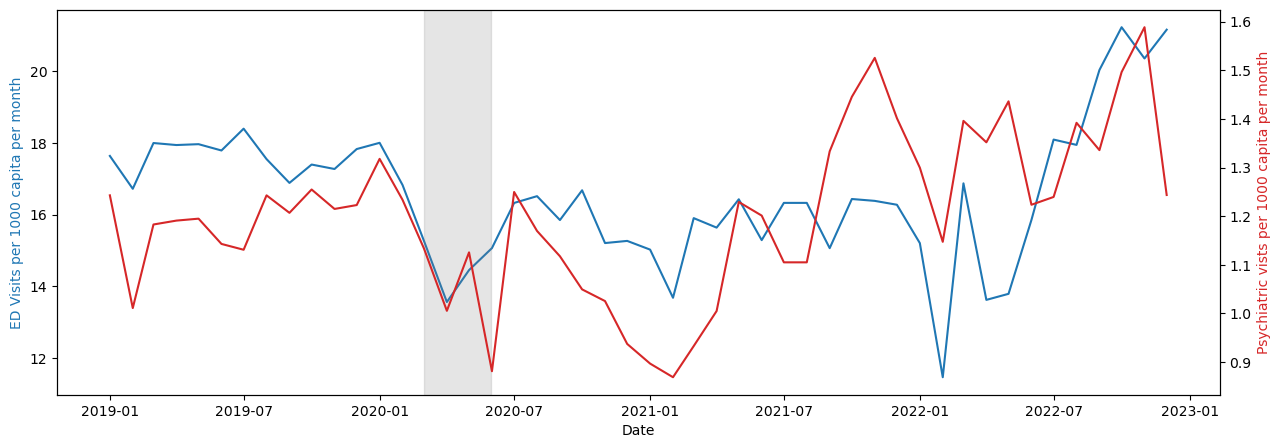

In [27]:
print(f"Visits per capita (per 1000)")
pand_start = '2020-01-01'
pand_3m = '2020-04-01'
pand_1y = '2021-01-01'
pre_start = '2019-01-01'
pre_3m = '2019-04-01'
pre_1y = '2020-01-01'

filters = {
    "1y" : {
        "start" : datetime(2020, 1, 1),
        "end" : datetime(2021, 1, 1),
        "pre_start" : datetime(2019, 1, 1),
        "pre_end" : datetime(2020, 1, 1)
    },
    "3m" : {
        "start" : datetime(2020, 3, 1),
        "end" : datetime(2020, 6, 1),
        "pre_start" : datetime(2019, 3, 1),
        "pre_end" : datetime(2019, 6, 1)
    }
}

for df in [visits_df, visits_psych_df]:
    for key, value in filters.items():
        pand = df.loc[(df.index >= value['start']) & (df.index < value['end']) & (df.region != 'Riket'), 'visits_per_citizen']
        pre = df.loc[(df.index >= value['pre_start']) & (df.index < value['pre_end']) & (df.region != 'Riket'), 'visits_per_citizen']
        res = ttest_rel(pand, pre)
        print(f"{key} pandemic {pand.mean()} (SD {pand.std()})")
        print(f"{key} pre-pandemic {pre.mean()} (SD {pre.std()})")
        print(f"{pre.mean() - pand.mean()} ({res.confidence_interval()[0]} - {res.confidence_interval()[1]} (p {res.pvalue}))")


fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(visits_df.groupby('date')['visits_per_citizen'].mean(), label="Visits per 1000 capita per month", color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('ED Visits per 1000 capita per month', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(visits_psych_df.groupby('date')['visits_per_citizen'].mean(), label='Visits per 1000 capita per month', color='tab:red')
ax2.set_ylabel('Psychiatric vists per 1000 capita per month', color='tab:red')
plt.axvspan(datetime(2020, 3, 1), datetime(2020, 5, 31), alpha=0.2, color='grey')
plt.savefig(os.path.join(path, 'figures', 'figure_3_visits_per_capita.jpg'), dpi=600)

In [28]:
from scipy.stats import ttest_ind

cpc_march_2020 = tmp_df[tmp_df['date'] == '2020-03-31']['calls_per_capita']
cpc_other = tmp_df[(tmp_df['date'] < '2022-01-01') & (tmp_df['date'] != '2020-03-31')][['region', 'calls_per_capita']].groupby(by='region').mean()['calls_per_capita']
print(f"March 2020: {cpc_march_2020.mean()} Other months: {cpc_other.mean()}, diff: {cpc_march_2020.mean() - cpc_other.mean()} increase: {round((cpc_march_2020.mean() - cpc_other.mean())/cpc_other.mean()*100, 1)}%")
res = ttest_ind(cpc_march_2020, cpc_other)
print(f"diff: {cpc_march_2020.mean() - cpc_other.mean()} ({res.confidence_interval()[0]} - {res.confidence_interval()[1]} (p {res.pvalue}))")


March 2020: 62.178462987351686 Other months: 48.02450020550349, diff: 14.153962781848193 increase: 29.5%
diff: 14.153962781848193 (9.030120853203613 - 19.277804710492774 (p 1.821290054012124e-06))
